In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pycbc.psd as psd_func
from pycbc.filter import match
from pesummary.gw.conversions.mass import component_masses_from_mchirp_q, q_from_eta
from simple_pe.waveforms import make_waveform, shifted_f

# Disable pesummary warnings
import logging
_logger = logging.getLogger('PESummary')
_logger.setLevel(logging.CRITICAL + 10)

# Otherwise plt.savefig crashes with latex errors
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# Parameter settings

In [104]:
f_low = 10
sample_rate = 4096
tlen = 32

# Create psd
ifos = ['H1']
psds = {'H1': 'aLIGOZeroDetHighPower',
        'f_low': f_low,
        'f_high': int(sample_rate/2),
        'length': tlen,
        'delta_f': 1. / tlen
        }
psd = {}
for ifo in ifos:
    psd[ifo] = psd_func.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                     psds['f_low'])

params = {'ecc10sqrd': 0.02**2, 'chirp_mass': 24, 'symmetric_mass_ratio': 2/9, 'chi_eff': 0, 'distance': 1}

# Match vs shift

51 out of 51 done

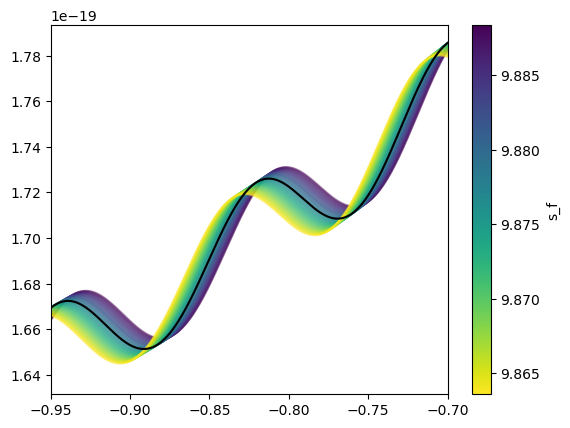

In [105]:
hp, hc = make_waveform(params, psd['H1'].delta_f, f_low, len(psd['H1']), approximant='TEOBResumS-Dali', return_hc=True)
h = hp.to_timeseries() - 1j*hc.to_timeseries()
plt.plot(h.sample_times, np.abs(h), c='k', zorder=5)
zero_params = params.copy()
zero_params['ecc10sqrd'] = 0
h0p, h0c = make_waveform(zero_params, psd['H1'].delta_f, f_low, len(psd['H1']), approximant='TEOBResumS-Dali', return_hc=True)
h0 = h0p.to_timeseries() - 1j*h0c.to_timeseries()
q = 1/q_from_eta(params['symmetric_mass_ratio'])
M = np.sum(component_masses_from_mchirp_q(params['chirp_mass'], q))
s_f_2pi = f_low - shifted_f(f_low, params['ecc10sqrd']**0.5, M, q)
s_fs = f_low - np.linspace(0.9, 1.1, 51)*s_f_2pi
matches = []
zero_matches = []
cmap = mpl.colormaps['viridis']
colors = cmap(np.linspace(0, 1, len(s_fs)))
for i, s_f in enumerate(s_fs):
    sp, sc = make_waveform(params, psd['H1'].delta_f, s_f, len(psd['H1']), approximant='TEOBResumS-Dali', return_hc=True)
    s = sp.to_timeseries() - 1j*sc.to_timeseries()
    plt.plot(s.sample_times, np.abs(s), alpha=0.5, c=colors[i]) 
    m, _ = match(s.real(), h.real(), psd=psd['H1'], low_frequency_cutoff=f_low, subsample_interpolation=True)
    matches.append(m)
    s0p, s0c = make_waveform(zero_params, psd['H1'].delta_f, s_f, len(psd['H1']), approximant='TEOBResumS-Dali', return_hc=True)
    s0 = s0p.to_timeseries() - 1j*s0c.to_timeseries()
    m, _ = match(s0.real(), h0.real(), psd=psd['H1'], low_frequency_cutoff=f_low, subsample_interpolation=True)
    zero_matches.append(m)
    print(f'\r{i+1} out of {len(s_fs)} done', end='')
sm = mpl.cm.ScalarMappable(cmap=cmap.reversed(), norm=mpl.colors.Normalize(s_fs[-1], s_fs[0]))
plt.colorbar(sm, ax=plt.gca(), label="s_f")
x_min, x_max = -0.95, -0.7
plt.xlim(x_min, x_max)
plot_inds = np.where(np.logical_and(s.sample_times>x_min, s.sample_times<x_max))[0]
h_min, h_max = np.min(np.abs(s[plot_inds])), np.max(np.abs(s[plot_inds]))
plt.ylim(h_min-(h_max-h_min)*0.1, h_max+(h_max-h_min)*0.1)
plt.show()

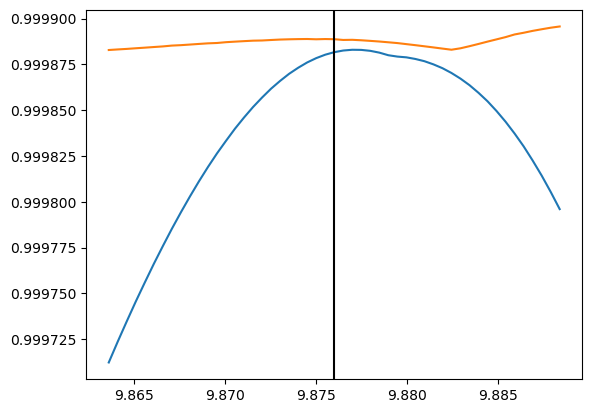

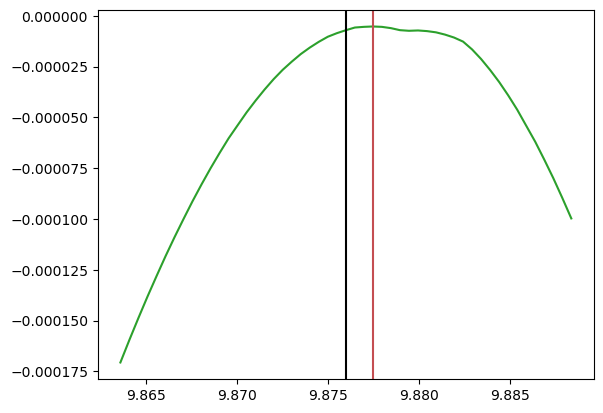

In [106]:
plt.plot(s_fs, matches)
plt.plot(s_fs, zero_matches)
plt.axvline(f_low-s_f_2pi, c='k')
plt.show()

plt.plot(s_fs, np.array(matches)-np.array(zero_matches), c='C2')
plt.axvline(f_low-s_f_2pi, c='k')
plt.axvline(s_fs[np.argmax(np.array(matches)-np.array(zero_matches))], c='r')
plt.show()